In [50]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import datetime
import itertools
import numpy as np
import types
import pickle
import os
import glob
import rasterio
import obspy
from obspy.signal.cross_correlation import correlate, xcorr_max
from pyproj import Proj,transform,Geod
from scipy.signal import find_peaks,hilbert,butter,filtfilt,correlate,correlation_lags,welch
from scipy.integrate import odeint
from scipy.ndimage import label, binary_fill_holes
from skimage.transform import resize
from skimage.morphology import dilation, erosion, skeletonize, binary_closing
from skimage.filters import gaussian
import skan
from image_analysis.fracture_mapping import clip, align_images, binary_threshold, read_tsx, plot_fracture_imagery
from seismic_analysis.preprocessing import download_data,remove_ir,taper_and_filter
from seismic_analysis.visualization import (plot_spectrogram,compute_psd,plot_spectra_and_timeseries,
                                plot_tilt_psd_ratio,plot_ringdown,particle_motion)
from seismic_analysis.attenuation import estimate_Q,estimate_ringdown
from seismic_analysis.location import (compute_backazimuths,get_station_lon_lat,get_crs_locations,travel_time,
                                get_station_grid_locations,load_data,get_grid,get_arrivals,get_velocities,
                                gridsearch,transform_imagery,plot_imagery_seismic_location)
from seismic_analysis.directivity import get_velocity, get_characteristic_frequency
from modeling.viscoelastic_beam import get_coefficients,asymptotic_solution,decay_comparison_plot, resonance
from modeling.elastic_beam import fg_dispersion_coeffs
from modeling.fluid_fracture import find_min_rxx,model_fracture, model_fracture_no_coupling, model_fracture_stopping, plot_fractures

In [51]:
def model_fracture_stopping(y, t, epsilon, L1, H_i, Rxx, w0):
    # get variables and set parameters
    eta, d_eta_dt, L = y
    g = 9.8
    v_r = 2000
    K_c = 1e5
    rho_i = 910
    rho_w = 1000
    H_w = rho_i/rho_w * H_i
    
    # calculate stress and stress intensity factor
    sigma = rho_i*g*H_i/2 - rho_w*g/(2*H_i)*eta**2
    sigma_sum = Rxx - sigma
    K_i = stress_intensity(L,sigma_sum)
    
    # use stress intensity factor to determine if crack propagates
    if L < L1:
        if K_i < K_c:
            dLdt = 0
        else:
            dLdt = v_r * (1 - (K_c/K_i)**2)
    if L > L1:
        dLdt = 0
        
    # use "Eshelby" relation to get width and its time derivative as a function of length
    mu_star = 3.6e9/(1-0.33)
    alpha = sigma_sum / mu_star * np.pi/4
    w = w0 + alpha * L

    # write time derivative of stress sum
    d_sigma_sum_dt = d_eta_dt*eta*rho_w*g/H_i
    
    # write time derivative of alpha
    d_alpha_dt = d_sigma_sum_dt*np.pi/mu_star/4
    
    # write time derivative of width
    dwdt = alpha*dLdt + d_alpha_dt*L
        
    # write time derivative of water volume, V'
    dVdt = w*L*d_eta_dt + w*dLdt*eta + dwdt*L*eta

    # write 2nd time derivative of crack length
    dLd2t = (v_r*K_c**2)/np.pi * (1/((L**2)*(sigma_sum**3))*(dLdt*sigma_sum + 2*L*d_sigma_sum_dt))
    if L > L1:
        dLd2t = 0
        
    # write expression for terms of V" that do not contain eta"
    gamma = rho_w*g*np.pi/4/H_i/mu_star
    lamb = 2*(w*dLdt*d_eta_dt + dwdt*L*d_eta_dt + dwdt*dLdt*eta) + w*dLd2t*eta + L*eta*(alpha*dLd2t + 2*d_alpha_dt*dLdt + gamma*L*d_eta_dt**2)
    beta = L*(w + gamma*L*eta**2)
    
    # write bernoulli with u' substituted in so all eta" terms can be moved to LHS
    d_eta_d2t = (H_w + epsilon*beta/L)**-1 * (g*(H_w - eta) - (epsilon/L**2)*(lamb*L - dVdt*dLdt))
    
    dydt = [d_eta_dt, d_eta_d2t, dLdt]
    
    return dydt

def stress_intensity(L,sigma):
    return sigma*np.sqrt(np.pi*L)

Optimization terminated successfully.
         Current function value: 0.000385
         Iterations: 39
         Function evaluations: 78


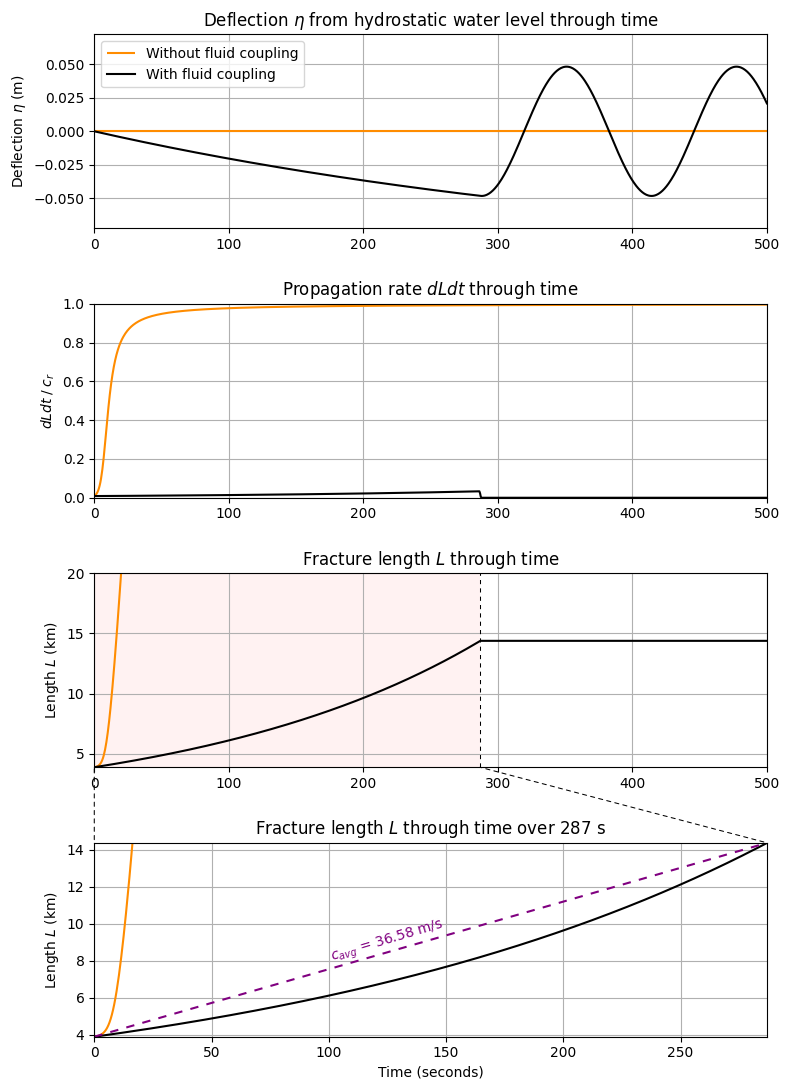

Mean crack propagation rate (epsilon=40): 36.58  m/s
Mean crack propagation rate with no coupling (epsilon=40): 1868.6  m/s


In [72]:
'''

Model coupled fluid-fracture system with stopping length

'''


H_i = 200
rho_i = 910
rho_w = 1000
H_w = rho_i/rho_w * H_i
g = 9.8
c_r = 2000
eta0 = H_w
d_eta_dt0 = 0
L0 = 3890
w0 = 91
K_ic = 1e5
sigma0 = -rho_i*g*H_i/2 + rho_w*g/(2*H_i)*eta0**2
epsilon = 40

# set stopping length 
L1 = L0 + 10500

# The following calculates Rxx such that K_ic = K_i, and then adds a tiny perturbation
Rxx = find_min_rxx(L0,sigma0,K_ic)[0]+4

# run model with fluid coupling for long timescale
t = np.linspace(0, 500, 1000)
y0 = [eta0, d_eta_dt0,L0]
sol = odeint(model_fracture_stopping, y0, t, args=(epsilon, L1, H_i, Rxx, w0))

# run model without fluid coupling
y0 = [L0]
sol_no_coupling = odeint(model_fracture_no_coupling, y0, t, args=(epsilon, H_i, Rxx, w0))

# get some useful variables
dLdt = np.gradient(sol[:, 2],t)
dLdt_no_coupling = np.gradient(sol_no_coupling[:, 0],t)

# subset before length
L = sol[:, 2]
idx = np.where(L < L1)[0]
dLdt = np.gradient(sol[:,2][idx],t[idx])
c_avg = np.round(np.mean(dLdt),2)
dLdt_no_coupling = np.gradient(sol_no_coupling[:,0][idx],t[idx])

# plot fracture
eta_lims = [1.5*(np.min(sol[:,0])-H_w),1.5*(np.max(sol[:,0])-H_w)]
plot_fractures(t,sol,sol_no_coupling,c_r,H_w,L0,L1,c_avg,[eta_lims,[0,1],[L0/1000,20],[L0/1000,L1/1000]])

# report average propagation rate
print("Mean crack propagation rate (epsilon="+str(epsilon)+"):",np.round(np.mean(dLdt),2)," m/s")
print("Mean crack propagation rate with no coupling (epsilon="+str(epsilon)+"):",np.round(np.mean(dLdt_no_coupling),2)," m/s")